In [1]:
import os, sys
sys.path.append(os.path.join('/home/ring/sumo-svn/', 'tools'))
import traci
import traci.constants as tc
import numpy as np
from sumolib import checkBinary
import datetime
import matplotlib
import matplotlib.pyplot as plt
import torch
import copy

In [2]:
#reset the environment
def reset():
    sumoBinary = checkBinary('sumo-gui')
    traci.start([sumoBinary, "-c", "Onnut/onnut.sumocfg",
                             "--tripinfo-output", "tripinfo.xml", '--start','true','--quit-on-end','true','--time-to-teleport','-1'])

In [3]:
id = {'Onnut': 'cluster_1088409501_272206263_5136790697_70702637'}
number_phase = [2]
# detecters = {'QA' : ['156261350#0'], 'QB' : ['-453962283#3'], 'QC' : ['459551209#0', '459551209#3'], 'QD' : ['27702347#0', '27702347#4', '27702347#6']}

In [4]:
Onnut_edge = {'WB' : ['156591171#2', '156591171#0', '-824456409#0'], 
         'SB': ['824116560#3' ,'824116560#1', '824116560#0', '824816455'],
         'NB': ['751454884#3']}
OnnutArea_edge = [Onnut_edge]

In [5]:
Onnut_detector_id = {'WB': [['156591171#2_0', '156591171#2_1', '156591171#2_2'], ['156591171#0_0', '156591171#0_1', '156591171#0_2'], ['-824456409#0_0', '-824456409#0_1']], 
 'SB': [['824116560#3_0', '824116560#3_1', '824116560#3_2', '824116560#3_3'], ['824116560#1_0', '824116560#1_1', '824116560#1_2', '824116560#1_3'], ['824116560#0_0', '824116560#0_1', '824116560#0_2', '824116560#0_3'], ['824816455_0', '824816455_1', '824816455_2']], 
 'NB': [['751454884#3_0', '751454884#3_1', '751454884#3_2']]}
OnnutArea_detector_id = [Onnut_detector_id]

In [6]:
# import traci
# import lxml.etree as ET
# def get_Onnut_id():
#     tree = ET.parse('Onnut/detectors_01.add.xml')
#     additionals = tree.getroot()
#     for junction in OnnutArea:
# #         print(junction)
#         for key in junction.keys():
#             detectors_id = []
# #             print(key)
#             for detectors in junction[key]:
# #                 print(detectors)
#                 detector_id = []
#                 for e2Detector in additionals:
#                     detector = e2Detector.attrib
#                     if 'id' in detector.keys():
#                         if detectors == detector['id'][:-2]:
#                             detector_id.append(detector['id'])
#                 detectors_id.append(detector_id)
#             junction[key] = detectors_id
#     for junction in OnnutArea:
#         print(junction)
#     return 
# get_Onnut_id()

In [7]:
def get_detector_id(list_detector):
    detector_id = []
    for j in range(len(OnnutArea_edge)):
#         print(KasemArea[j])
        for key in OnnutArea_edge[j].keys():
            detectors_id = []
#             print(key)
            for i in range(len(OnnutArea_edge[j][key])):
                for d in list_detector:
                    if d == OnnutArea_edge[j][key][i]:
#                         print(Onnut_detector_id [j][key][i])
                        detector_id += OnnutArea_detector_id [j][key][i]
#                 print(detector_id)
    return detector_id
get_detector_id(['824116555#0-AddedOffRampEdge', '824116555#0'])

[]

In [8]:
def get_occupancy_average_percent(detector_id): #get_occupancy_average
    occupancy = sum([traci.lanearea.getLastStepOccupancy(e) for e in detector_id])/len(detector_id)
    return occupancy

In [9]:
def get_flow_sum(detector_id):
    #https://sumo.dlr.de/docs/TraCI/Lane_Area_Detector_Value_Retrieval.html
    flow = sum([traci.lanearea.getLastStepVehicleNumber(e) for e in detector_id])#-sum([traci.lanearea.getJamLengthVehicle(e) for e in detector_id])
    return flow

In [10]:
def get_mean_speed(detector_id):
    mean_speed = sum([traci.lanearea.getLastStepMeanSpeed(e) for e in detector_id])/len(detector_id)

In [11]:
def get_unjamlength_meters(detector_id): #get_unjamlength ไม่เอา percent เปลี่ยนนนนนน
    detector_length = sum(traci.lanearea.getLength(d) for d in detector_id)
    unjamlength = detector_length - (sum([traci.lanearea.getJamLengthMeters(e) for e in detector_id])) #/detector_length
    return unjamlength

In [12]:
list(id.keys())

['Onnut']

In [49]:
junction_name = list(id.keys()) 
def take_action(action):
    change_to_phase = action
    current_phase = [traci.trafficlight.getPhase(id[key]) for key in id.keys()]
    for i in range(len(current_phase)):
        if change_to_phase[i*2] != current_phase[i]:
            yellow = (change_to_phase[i*2]-1)%(2*number_phase[i])
#             print(yellow)
#             print(junction_name[i])
            traci.trafficlight.setPhase(id[junction_name[i]], yellow) #  YELLOW PHASE 
        else:
            traci.trafficlight.setPhase(id[junction_name[i]], change_to_phase[i*2]) # No YELLOW PHASE 
    for i in range(5):
        traci.simulationStep()
#     w1 = sum([traci.lanearea.getLastStepOccupancy(e) for e in get_edge_id(reward_w1)])
#     w2 = sum([traci.lanearea.getLastStepOccupancy(e) for e in get_edge_id(reward_w1)])
    JamLengthMeter = sum([traci.lanearea.getJamLengthMeters(detector) for i in range (len(OnnutArea_detector_id)) for B in OnnutArea_detector_id[i].keys() for detectors in OnnutArea_detector_id[i][B] for detector in detectors])
#     reward = -w2*(1-w) - w1*(w)
#     state, len_state = get_state()
    Speed = sum([traci.lanearea.getLastStepMeanSpeed(detector) for i in range (len(OnnutArea_detector_id)) for B in OnnutArea_detector_id[i].keys() for detectors in OnnutArea_detector_id[i][B] for detector in detectors])
    reward = JamLengthMeter, Speed
    return reward

In [50]:
#max_greentime !!!

In [51]:
def traffic_police_action(action, count, threshold, max_duration): 
    #Onnut
    current_phase = action[0]
    next_phase = action[1]
#     print('get_flow_sum(get_detector_id(Onnut_edge[WB]))', get_flow_sum(get_detector_id(Onnut_edge['WB'])))
#     print('get_flow_sum(get_detector_id(Onnut_edge[SB]))', get_flow_sum(get_detector_id(Onnut_edge['SB'])))
#     print('unjamlength_meters Onnut_edge WB', get_unjamlength_meters(get_detector_id(Onnut_edge['WB'])))
#     print('occupancy Onnut_edge SB', get_occupancy_average_percent(get_detector_id(Onnut_edge['SB'])))
    if current_phase == 0:
        if (get_flow_sum(get_detector_id(Onnut_edge['SB'])) <= threshold['0_finish']) or (count >= max_duration['0_finish']): 
              current_phase = 2
        if get_unjamlength_meters(get_detector_id(Onnut_edge['WB'])) <= threshold['0_2']:
              current_phase = 2
    elif current_phase == 2: #***
        if get_flow_sum(get_detector_id(Onnut_edge['WB'])) <= threshold['2_finish'] or count >= max_duration['2_finish']:
              current_phase = 0
    if action[0] == current_phase:
        count += 5
    else: count = 0
    Onnut_phase = current_phase
    next_Onnut_phase = None
    action = [Onnut_phase, next_Onnut_phase]
#     action = [ KlongTei_phase, None, Rama4_phase,  next_Rama4_phase, 0, None, 0, None, 0, None, 0, None]
    return action, count

In [52]:
reward_memory = []
def plot_durations():
    print('show')
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(reward_memory, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Step')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

In [81]:
traci.close()

In [82]:
def episode0(threshold, max_duration):
    #episode = 0
    reward_memory = []
    JamLengthMeter_memory = []
    Speed_memory = []
    count = 0
    reset()
    traci.simulationStep()
    action = [0, None]
    for seconds in range(1000): #2880
#         state, len_state = get_state() #minimum_remaining_time = Q-lengthเมตร/free flow speed
        action, count = traffic_police_action(action, count, threshold, max_duration) #initial >> traffic_police_action(detector_id, action, threshold)
#         print(action)
#         print(count)
        JamLengthMeter, Speed = take_action(action)
        JamLengthMeter_memory.append(JamLengthMeter)
        Speed_memory.append(Speed)
#         print(JamLengthMeter_memory)
#         print(state)
    plt.figure(2)
    plt.clf() 
    line_up, = plt.plot(JamLengthMeter_memory)
    line_down, = plt.plot(Speed_memory)
    plt.legend([line_up, line_down], ['JamLengthMeter', 'Speed'])
    plt.pause(0.001)
    traci.close()

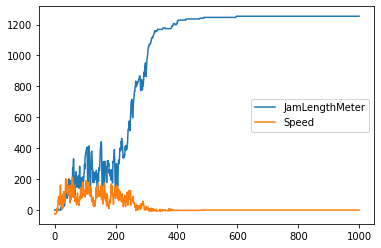

In [83]:
threshold = {'0_finish': 20 , '0_2': 150, '2_finish': 5}
max_duration = {'0_finish': 90 , '2_finish': 60 }
episode0(threshold, max_duration) #PEAM